# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from sklego.preprocessing import RepeatingBasisFunction

# Dataset Generation

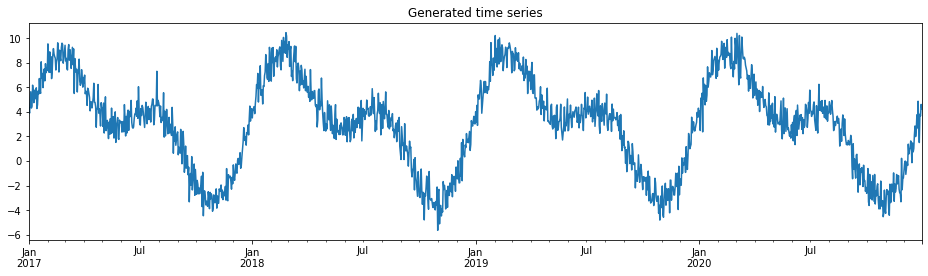

In [2]:
# for reproducibility
np.random.seed(42)
# generate the DataFrame with dates
range_of_dates = pd.date_range(start="2017-01-01", end="2020-12-30")
X = pd.DataFrame(index=range_of_dates)
# create a sequence of day numbers
X["day_nr"] = range(len(X))
X["day_of_year"] = X.index.day_of_year
# generate the components of the target
signal_1 = 3 + 4 * np.sin(X["day_nr"] / 365 * 2 * np.pi)
signal_2 = 3 * np.sin(X["day_nr"] / 365 * 4 * np.pi + 365/2)
noise = np.random.normal(0, 0.85, len(X))
# combine them to get the target series
y = signal_1 + signal_2 + noise
# plot
y.plot(figsize=(16,4), title="Generated time series");

In [3]:
results_df = y.to_frame()
results_df.columns = ["actuals"]

In [4]:
results_df

,actuals
2017-01-01,4.273237
2017-01-02,3.900877
2017-01-03,4.735163
2017-01-04,5.644148
2017-01-05,4.314070
...,...
2020-12-26,1.505175
2020-12-27,3.813185
2020-12-28,3.667402
2020-12-29,4.609689


# Creation of Time Related Features

In [5]:
# index for the end of train set

TRAIN_END = 3 * 365  # 3 years

### Approach 1. Dummy Variables (One-Hot Encoding)

In [6]:
X_1 = pd.DataFrame(
    data=pd.get_dummies(X.index.month, drop_first=True, prefix="month")
)

# we have dropped one level (by using drop_first=True) and only have 11 columns now.
# We have done that in order to avoid the infamous dummy variable trap (perfect multicollinearity),

X_1.index = X.index
X_1

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2017-01-01,0,0,0,0,0,0,0,0,0,0,0
2017-01-02,0,0,0,0,0,0,0,0,0,0,0
2017-01-03,0,0,0,0,0,0,0,0,0,0,0
2017-01-04,0,0,0,0,0,0,0,0,0,0,0
2017-01-05,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,0,0,0,0,0,0,0,0,0,0,1
2020-12-27,0,0,0,0,0,0,0,0,0,0,1
2020-12-28,0,0,0,0,0,0,0,0,0,0,1
2020-12-29,0,0,0,0,0,0,0,0,0,0,1


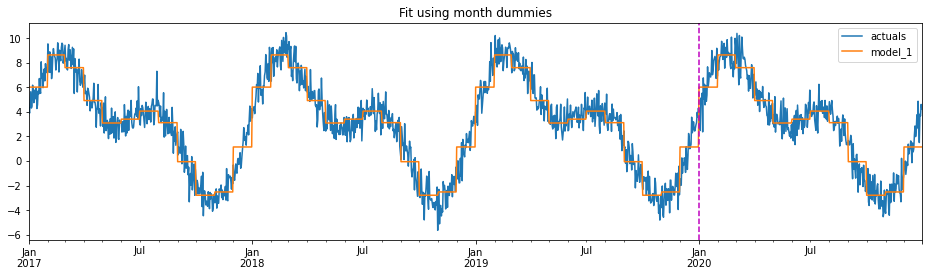

In [7]:
model_1 = LinearRegression().fit(X_1.iloc[:TRAIN_END], y.iloc[:TRAIN_END])

results_df["model_1"] = model_1.predict(X_1)

results_df[["actuals", "model_1"]].plot(
    figsize=(16,4), title="Fit using month dummies"
)

plt.axvline(date(2020, 1, 1), c="m", linestyle="--");

### Approach 2. Cyclical Encoding with Sine/Cosine Transformation

In [8]:
def sin_transformer(period):
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

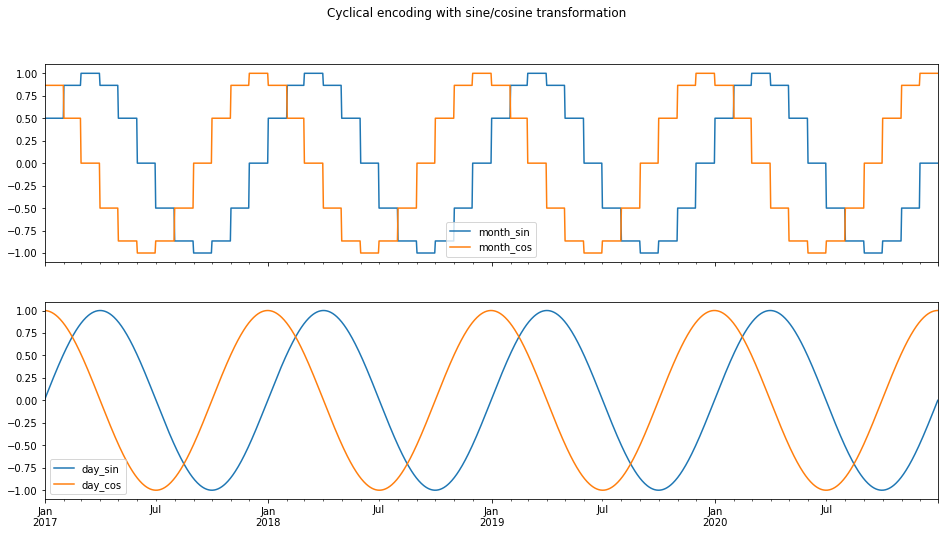

In [9]:
X_2 = X.copy()
X_2["month"] = X_2.index.month
X_2["month_sin"] = sin_transformer(12).fit_transform(X_2["month"])
X_2["month_cos"] = cos_transformer(12).fit_transform(X_2["month"])
X_2["day_sin"] = sin_transformer(365).fit_transform(X_2["day_of_year"])
X_2["day_cos"] = cos_transformer(365).fit_transform(X_2["day_of_year"])
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16,8))
X_2[["month_sin", "month_cos"]].plot(ax=ax[0])
X_2[["day_sin", "day_cos"]].plot(ax=ax[1])
plt.suptitle("Cyclical encoding with sine/cosine transformation");

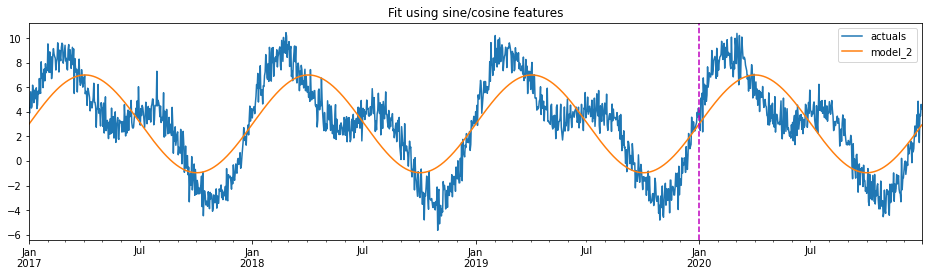

In [10]:
X_2_daily = X_2[["day_sin", "day_cos"]]

model_2 = LinearRegression().fit(X_2_daily.iloc[:TRAIN_END], y.iloc[:TRAIN_END])

results_df["model_2"] = model_2.predict(X_2_daily)

results_df[["actuals", "model_2"]].plot(figsize=(16,4),
                                        title="Fit using sine/cosine features")
plt.axvline(date(2020, 1, 1), c="m", linestyle="--");

### Approach 3. Radial Basis Function

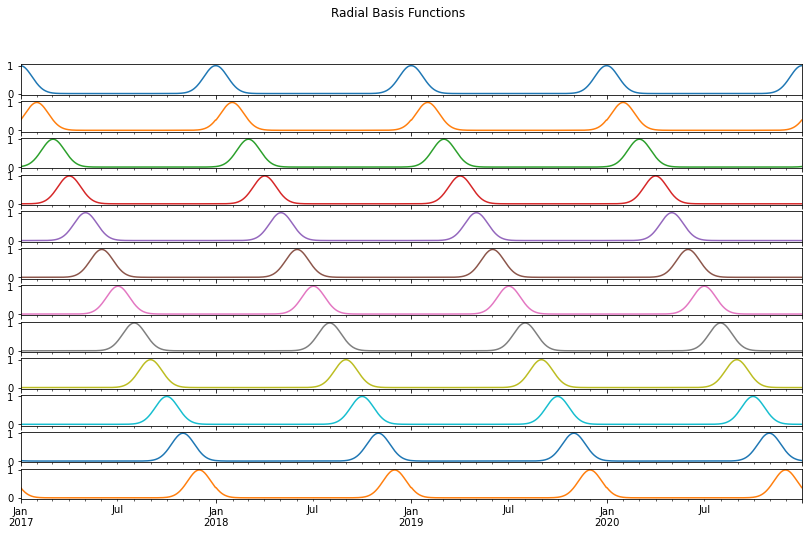

In [11]:
# Similar to Approach 1, but continuous

rbf = RepeatingBasisFunction(n_periods=12,
                             column="day_of_year",
                             input_range=(1,365),
                             remainder="drop")  
# "drop” will only keep the created RBF features, ”passthrough” will keep both the old and new features

rbf.fit(X)

X_3 = pd.DataFrame(index=X.index, data=rbf.transform(X))

X_3.plot(subplots=True,
         figsize=(14, 8),
         sharex=True,
         title="Radial Basis Functions",
         legend=False);

In [12]:
X_3

,0,1,2,3,4,5,6,7,8,9,10,11
2017-01-01,1.000000,0.367879,0.018316,0.000123,1.125352e-07,1.388794e-11,2.319523e-16,1.388794e-11,1.125352e-07,0.000123,0.018316,0.367879
2017-01-02,0.998914,0.392526,0.020875,0.000150,1.463375e-07,1.929034e-11,3.441402e-16,9.976816e-12,8.635293e-08,0.000101,0.016035,0.344032
2017-01-03,0.995662,0.417914,0.023740,0.000183,1.898798e-07,2.673609e-11,5.094813e-16,7.151579e-12,6.611833e-08,0.000083,0.014009,0.321032
2017-01-04,0.990266,0.443978,0.026939,0.000221,2.458430e-07,3.697532e-11,7.526222e-16,5.115262e-12,5.051527e-08,0.000068,0.012211,0.298919
2017-01-05,0.982761,0.470644,0.030503,0.000268,3.176092e-07,5.102487e-11,1.109384e-15,3.650816e-12,3.851052e-08,0.000055,0.010622,0.277725
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,0.982761,0.277725,0.010622,0.000055,3.851052e-08,3.650816e-12,1.109384e-15,5.102487e-11,3.176092e-07,0.000268,0.030503,0.470644
2020-12-27,0.990266,0.298919,0.012211,0.000068,5.051527e-08,5.115262e-12,7.526222e-16,3.697532e-11,2.458430e-07,0.000221,0.026939,0.443978
2020-12-28,0.995662,0.321032,0.014009,0.000083,6.611833e-08,7.151579e-12,5.094813e-16,2.673609e-11,1.898798e-07,0.000183,0.023740,0.417914
2020-12-29,0.998914,0.344032,0.016035,0.000101,8.635293e-08,9.976816e-12,3.441402e-16,1.929034e-11,1.463375e-07,0.000150,0.020875,0.392526


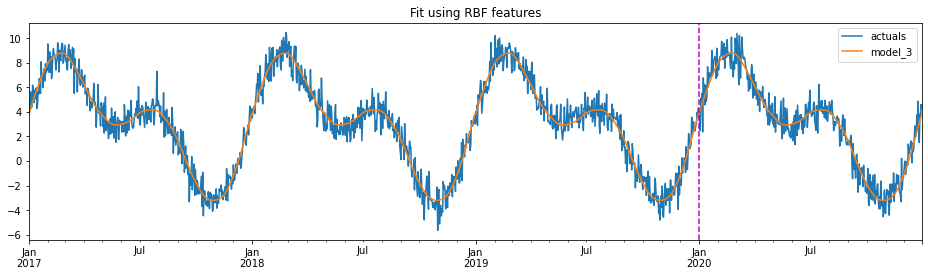

In [13]:
model_3 = LinearRegression().fit(
    X_3.iloc[:TRAIN_END],y.iloc[:TRAIN_END]
)

results_df["model_3"] = model_3.predict(X_3)
results_df[["actuals", "model_3"]].plot(figsize=(16,4),
                                        title="Fit using RBF features")
plt.axvline(date(2020, 1, 1), c="m", linestyle="--");

# Final Comparison

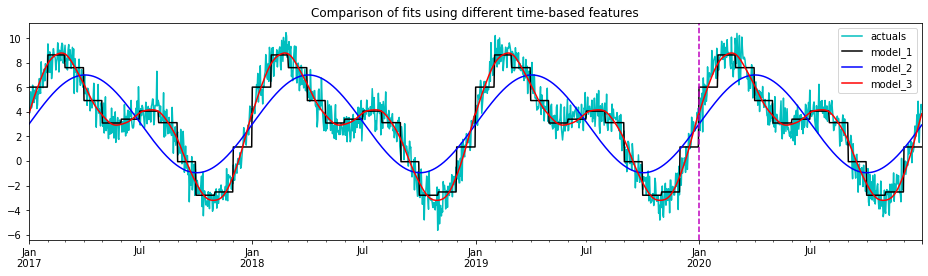

In [14]:
results_df.plot(title="Comparison of fits using different time-based features",
                figsize=(16,4),
                color=["c", "k", "b", "r"])

plt.axvline(date(2020, 1, 1), c="m", linestyle="--");

In [15]:
score_list = []
for fit_col in ["model_1", "model_2", "model_3"]:
    scores = {
        "model": fit_col,
        "train_score": mean_absolute_error(
            results_df.iloc[:TRAIN_END]["actuals"],
            results_df.iloc[:TRAIN_END][fit_col]
        ),
        "test_score": mean_absolute_error(
            results_df.iloc[TRAIN_END:]["actuals"],
            results_df.iloc[TRAIN_END:][fit_col]
        )
    }
    score_list.append(scores)
    
scores_df = pd.DataFrame(score_list)
scores_df

,model,train_score,test_score
0,model_1,0.876548,0.925758
1,model_2,1.976644,1.990182
2,model_3,0.657744,0.692134
